In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 785 kB/994 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.12
Err:1 http://security.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.12
  404  Not Found [IP: 185.125.190.39 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.19.6-1ubuntu4.12_amd64.deb  404  Not Found [IP: 185.125.190.39 80]
E: Unable to fetch s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import cv2
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make("LunarLander-v2").unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


#DQN

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, inFeatures, actionSize):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(inFeatures, 64)
        self.lin2 = nn.Linear(64,64)
        self.head = nn.Linear(64, actionSize)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.head(x)

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TARGET_UPDATE = 10
TAU = 0.001


n_actions = env.action_space.n

policy_net = DQN(8, n_actions).to(device)
target_net = DQN(8, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=0.0001, weight_decay=0.01, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.show()

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

<ipython-input-14-6e8af7638d00>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.tensor([state], device=device)


0: Ep done; Duration : 94
1: Ep done; Duration : 90
2: Ep done; Duration : 75
3: Ep done; Duration : 108
4: Ep done; Duration : 83
5: Ep done; Duration : 68
6: Ep done; Duration : 85
7: Ep done; Duration : 90
8: Ep done; Duration : 75
9: Ep done; Duration : 57
10: Ep done; Duration : 101
11: Ep done; Duration : 267
12: Ep done; Duration : 74
13: Ep done; Duration : 130
14: Ep done; Duration : 62
15: Ep done; Duration : 169
16: Ep done; Duration : 150
17: Ep done; Duration : 558
18: Ep done; Duration : 144
19: Ep done; Duration : 1001
20: Ep done; Duration : 497
21: Ep done; Duration : 422
22: Ep done; Duration : 174
23: Ep done; Duration : 209
24: Ep done; Duration : 305
25: Ep done; Duration : 356
26: Ep done; Duration : 296
27: Ep done; Duration : 282
28: Ep done; Duration : 331
29: Ep done; Duration : 228
30: Ep done; Duration : 140
31: Ep done; Duration : 249
32: Ep done; Duration : 250
33: Ep done; Duration : 242
34: Ep done; Duration : 271
35: Ep done; Duration : 304
36: Ep done;

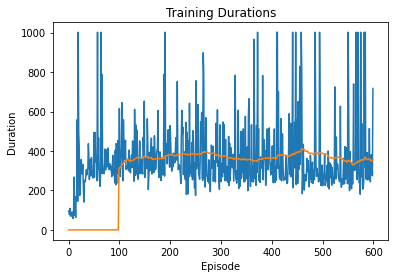

[-391.03937917411884, -343.661131407879, -334.68466444570674, -232.81494084697337, -109.07108521449962, -117.17431724009967, -329.097344923628, -167.28275183607445, -66.4170991849318, -131.3287598818494, -285.00410887971253, -542.7568770348718, -198.29476593381176, -207.72381973133102, -133.17925416819224, -485.8405696574194, -199.32668116040145, -94.31008926308206, -232.69974189719292, -124.54732159033016, -342.68781846264494, -246.82811838446077, -237.69606704667274, -215.19929463275162, -230.45416865951583, -141.05576495501634, -216.79321138474734, -84.10899208662255, -144.27941566715617, -184.46218043342935, -154.91982776129154, -46.45589145633642, -247.02498637702115, -184.07003737236087, 21.0524739168182, -28.585203010330332, -225.44095053135942, -184.67284499031706, -75.1320418617499, -9.16344885683759, -87.24347024705595, -17.333998363836898, -203.2082964436791, -207.06129604196525, -22.04970333894093, -242.50519817562065, -7.514214098138126, -42.80481453225424, -0.322225625025

In [ ]:
num_episodes = 600
maxDuration = 0
best_net = DQN(8, n_actions).to(device)

i = 1
episode_durations = []

since = time.time()

totalRewards = []

for i_episode in range(num_episodes):
    env.reset()
    state,_,_,_,_ = env.step(env.action_space.sample())
    state = torch.tensor([state], device=device)
    score = 0
    for t in count():
        
        action = select_action(state)

        next_state, reward, done,_, info = env.step(action.item())
        score += reward
        reward = torch.tensor([reward], device=device)

        if done:
          next_state = None
        else:
          next_state = torch.tensor([next_state], device=device)

        memory.push(state, action, next_state, reward)
        state = next_state



        optimize_model()

        if (done or t > 1000):
            episode_durations.append(t + 1)
            break


        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for k in policy_net_state_dict:
            target_net_state_dict[k] = policy_net_state_dict[k]*TAU + target_net_state_dict[k]*(1-TAU)
        if t % TARGET_UPDATE == 0:
            torch.save(policy_net.state_dict(), '/content/drive/MyDrive/lunarPolicy')
    print(f'{i_episode}: Ep done; Duration : {t}')
    totalRewards.append(score)



print('Complete')
dqnTime = time.time() - since
print(f'DQN training time {dqnTime // 60:.0f}m {dqnTime % 60:.0f}s')
plot_durations()
print(totalRewards)

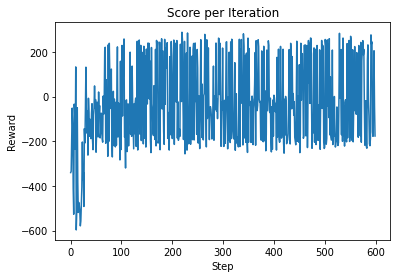

In [ ]:
fig, ax = plt.subplots()
scoreLength = range(len(totalRewards))
ax.plot(scoreLength, totalRewards)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Score per Iteration')
plt.show()

In [ ]:
torch.save(policy_net.state_dict(), '/content/drive/MyDrive/lunarPolicy')
torch.save(policy_net.state_dict(), 'currentPolicy')

In [ ]:
policy_net.load_state_dict(torch.load('/content/drive/MyDrive/lunarPolicy'))

<All keys matched successfully>

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
testVideo = "testVideo.mp4"
video = VideoRecorder(env, testVideo)
duration = 0
env.reset()
state,_,_,_,_ = env.step(env.action_space.sample())
state = torch.tensor([state], device=device)
from base64 import b64encode
def render_mp4(videopath: str) -> str:

  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:

steps = 0
reallyDone = False
while True:
  video.capture_frame()


  action = policy_net(state).max(1)[1].view(1, 1)
  next_state, reward, done,_, info = env.step(action.item())
  
  reward = torch.tensor([reward], device=device)
  next_state = torch.tensor([next_state], device=device)
 
  state = next_state
  if(reallyDone or steps > 3000):
    break
  if(done):
    reallyDone = True
  steps += 1

video.close()

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
from IPython.display import HTML
html = render_mp4(testVideo)
HTML(html)

#ACTOR CRITIC

In [ ]:
#This makes the actor network. It outputs a categorical distribution

from torch.distributions import Categorical
class Actor(nn.Module):
  def __init__(self, inputSize, outputSize):
    super(Actor, self).__init__()
    self.lin1 = nn.Linear(inputSize, 64)
    self.lin2 = nn.Linear(64,64)
    self.head = nn.Linear(64, outputSize)

  def forward(self, state):
    output = F.relu(self.lin1(state))
    output = F.relu(self.lin2(output))
    return Categorical(F.softmax(self.head(output), dim=-1))

In [ ]:
#This makes the critic network. It ouputs a value

class Critic(nn.Module):
  def __init__(self, inputSize):
    super(Critic, self).__init__()
    self.lin1 = nn.Linear(inputSize, 64)
    self.lin2 = nn.Linear(64,64)
    self.head = nn.Linear(64, 1)

  def forward(self, state):
    output = F.relu(self.lin1(state))
    output = F.relu(self.lin2(output))
    return self.head(output)

In [ ]:
n_actions = env.action_space.n
actor = Actor(8,n_actions).to(device)
critic = Critic(8).to(device)

actorOptimizer = optim.Adam(actor.parameters(), lr=0.0001, weight_decay=0.01, amsgrad=True)
criticOptimizer = optim.Adam(critic.parameters(), lr=0.0001, weight_decay=0.01, amsgrad=True)


def optimize(actorLoss, criticLoss):
  actorOptimizer.zero_grad()
  criticOptimizer.zero_grad()
  actorLoss.backward()
  criticLoss.backward()
  actorOptimizer.step()
  criticOptimizer.step()


0: Ep done; Duration: 91
1: Ep done; Duration: 93
2: Ep done; Duration: 104
3: Ep done; Duration: 94
4: Ep done; Duration: 83
5: Ep done; Duration: 86
6: Ep done; Duration: 106
7: Ep done; Duration: 117
8: Ep done; Duration: 75
9: Ep done; Duration: 92
10: Ep done; Duration: 92
11: Ep done; Duration: 91
12: Ep done; Duration: 93
13: Ep done; Duration: 112
14: Ep done; Duration: 104
15: Ep done; Duration: 159
16: Ep done; Duration: 108
17: Ep done; Duration: 86
18: Ep done; Duration: 106
19: Ep done; Duration: 77
20: Ep done; Duration: 103
21: Ep done; Duration: 98
22: Ep done; Duration: 125
23: Ep done; Duration: 103
24: Ep done; Duration: 97
25: Ep done; Duration: 139
26: Ep done; Duration: 107
27: Ep done; Duration: 85
28: Ep done; Duration: 74
29: Ep done; Duration: 104
30: Ep done; Duration: 83
31: Ep done; Duration: 79
32: Ep done; Duration: 121
33: Ep done; Duration: 66
34: Ep done; Duration: 128
35: Ep done; Duration: 144
36: Ep done; Duration: 95
37: Ep done; Duration: 80
38: E

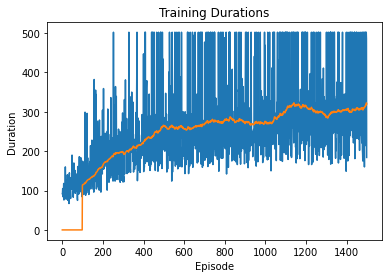

[-100.50894828045023, -510.1427825641483, -415.0103362570463, -189.3586827922399, -97.93211826645587, -100.39108645569857, -51.64582889133153, -292.1226973612647, -184.19906046250475, -72.87217309567993, -213.3072705139822, -287.46770740905197, -124.63495162829066, -102.34862039063034, -321.81232561701927, -245.79828383097274, -141.7299357506932, -267.70669333389947, -532.8840878306933, -190.20243689803078, -290.67281922938463, -122.59364822730672, -333.04651041343743, -91.44438950812376, -124.57674720228391, -99.45341345051241, -66.40608690394268, -387.5806673890473, -76.44044715739695, -356.85314627881917, -340.6627576544198, -161.06386065974542, -117.14121396800985, -100.68446747206953, -128.75209441246994, -229.54654496635314, -269.4608197272301, -197.61017404481785, -46.89391630600838, -250.62204295083552, -435.46589061730276, -77.7935103946185, -180.98850678129588, -288.3310400261598, -201.93073972147366, -170.13693960176187, -339.620401454833, -363.8324598252401, -163.9240284371

In [ ]:
num_episodes = 1500
DISCOUNT_FACTOR = 0.99
since = time.time()
scores = []
episode_durations = []

for iter in range(num_episodes):
  state = env.reset()
  state = torch.tensor([state], device=device)
  env.reset()
  score = 0
  I = 1
  for i in count():

    #Get outputs from the neural networks
    dist, currValue = actor(state), critic(state)
    action = dist.sample()

    next_state, reward, done,_, info = env.step(action.item())

    score += reward
    next_state = torch.tensor([next_state],device=device)
    nextValue = critic(next_state)

    if done:
      next_state = torch.tensor([0]).float().unsqueeze(0).to(device)
    #calculate the log probability of the policy distriution
    log_prob = dist.log_prob(action).unsqueeze(0)


    #Calculate the loss for the actor
    advantage = reward + DISCOUNT_FACTOR * nextValue.item()*(1-int(done)) - currValue.item()
    actor_loss = -log_prob * advantage
    actor_loss *= I
    
    #Calculate the loss for the critic
    critic_loss = F.mse_loss(reward+ DISCOUNT_FACTOR * nextValue, currValue)
    critic_loss *= I

    optimize(actor_loss, critic_loss)


    if (done or i > 500):
      episode_durations.append(i + 1)
      break
    state = next_state
    I *= DISCOUNT_FACTOR


  torch.save(actor.state_dict(), '/content/drive/MyDrive/lunarActor')
  torch.save(critic.state_dict(), '/content/drive/MyDrive/lunarCritic')
  print(f'{iter}: Ep done; Duration: {i}')
  scores.append(score)
actorCriticTime = time.time() - since
print(f'Actor Critic training time {actorCriticTime // 60:.0f}m {actorCriticTime % 60:.0f}s')
plot_durations()
print(scores)

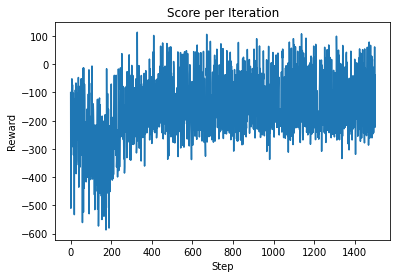

In [ ]:
fig, ax = plt.subplots()
scoreLength = range(len(scores))
ax.plot(scoreLength, scores)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Score per Iteration')
plt.show()

In [ ]:
torch.save(actor.state_dict(), 'actorNetwork')
torch.save(critic.state_dict(), 'criticNetwork')
torch.save(actor.state_dict(), '/content/drive/MyDrive/lunarActor')
torch.save(critic.state_dict(), '/content/drive/MyDrive/lunarCritic')

In [ ]:
actor.load_state_dict(torch.load('/content/drive/MyDrive/lunarActor', map_location = torch.device('cpu')))
critic.load_state_dict(torch.load('/content/drive/MyDrive/lunarCritic', map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
testVideo = "testVideo.mp4"
video = VideoRecorder(env, testVideo)
duration = 0
state = env.reset()
state = torch.tensor([state],device = device)
from base64 import b64encode
def render_mp4(videopath: str) -> str:

  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
reallyDone = False
steps = 0

while True:
  video.capture_frame()


  dist, value = actor(state), critic(state)

  action = dist.sample()
  next_state, reward, done,_, info = env.step(action.item())
  reward = torch.tensor([reward], device=device)
  next_state = torch.tensor([next_state], device=device)

  state = next_state
  steps += 1
  if(reallyDone):
    break
  if(done):
    reallyDone = True

video.close()

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
from IPython.display import HTML
html = render_mp4(testVideo)
HTML(html)

#Evaluation

92.76
70.86
433.91


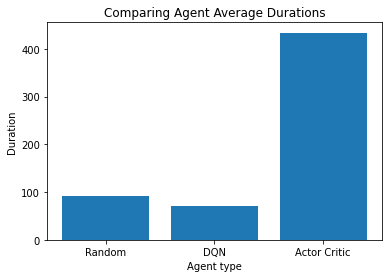

In [ ]:
randomTime = 0
dqnTime = 0
actorCriticTime = 0
for iterations in range(100):

  #Random
  state = env.reset()
  steps = 0
  while True:
    # Select and perform an action
    next_state, reward, done,_, info = env.step(env.action_space.sample())
    if(done or steps > 3000):
      break
    steps += 1
  randomTime += steps


  #DQN
  state = env.reset()
  state = torch.tensor([state], device=device)
  steps = 0
  while True:


    action = policy_net(state).max(1)[1].view(1, 1)
    next_state, reward, done,_, info = env.step(action.item())
    next_state = torch.tensor([next_state], device=device)
    # Move to the next state
    state = next_state
    if(done or steps > 3000):
      break
    steps += 1
  dqnTime += steps


  #Actor Critic
  state = env.reset()
  state = torch.tensor([state], device=device)
  steps = 0
  while True:

   # Select and perform an action
    dist, value = actor(state), critic(state)

    action = dist.sample()
    next_state, reward, done,_, info = env.step(action.item())
    next_state = torch.tensor([next_state], device=device)
    state = next_state
    if(done or steps > 3000):
      break
    steps += 1
  actorCriticTime += steps
print(randomTime/100)
print(dqnTime/100)
print(actorCriticTime/100)

agentName = ('Random', 'DQN', 'Actor Critic')
fig, ax = plt.subplots()
hbars = ax.bar(agentName, [(randomTime/100), (dqnTime/100), (actorCriticTime/100)])
ax.set_xlabel('Agent type')
ax.set_ylabel('Duration')
plt.title('Comparing Agent Average Durations')
plt.show()

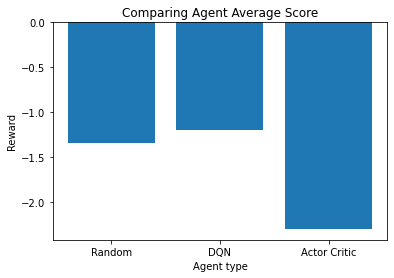

In [ ]:
randomTime = 0
dqnTime = 0
actorCriticTime = 0
for iterations in range(100):

  state = env.reset()
  steps = 0
  randomScore = 0
  while True:
    # Select and perform an action
    next_state, reward, done,_, info = env.step(env.action_space.sample())
    randomScore += reward
    if(done or steps > 3000):
      break
    steps += 1
  randomTime += steps



  state = env.reset()
  state = torch.tensor([state], device=device)
  steps = 0
  dqnScore = 0
  while True:

    # Select and perform an action
    action = policy_net(state).max(1)[1].view(1, 1)
    next_state, reward, done,_, info = env.step(action.item())
    dqnScore += reward
    next_state = torch.tensor([next_state], device=device)
    # Move to the next state
    state = next_state
    if(done or steps > 3000):
      break
    steps += 1
  dqnTime += steps


  #Actor Critic
  state = env.reset()
  state = torch.tensor([state], device=device)
  actorCriticScore = 0
  steps = 0
  while True:

   # Select and perform an action
    dist, value = actor(state), critic(state)

    action = dist.sample()
    next_state, reward, done,_, info = env.step(action.item())
    actorCriticScore += reward
    next_state = torch.tensor([next_state], device=device)
    state = next_state
    if(done or steps > 3000):
      break
    steps += 1
  actorCriticTime += steps


agentName = ('Random', 'DQN', 'Actor Critic')
fig, ax = plt.subplots()
hbars = ax.bar(agentName, [(randomScore/100), (dqnScore/100), (actorCriticScore/100)])
ax.set_xlabel('Agent type')
ax.set_ylabel('Reward')
plt.title('Comparing Agent Average Score')
plt.show()

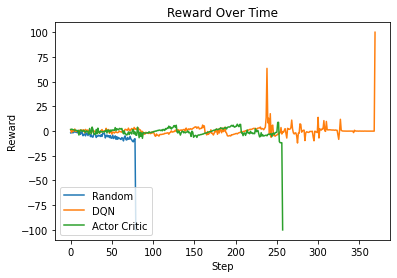

In [ ]:
randomReward = []
dqnReward = []
actorCriticReward = []


state = env.reset()
steps = 0
while True:
   # Select and perform an action
  next_state, reward, done,_, info = env.step(action.item())
  randomReward.append(reward)
  if(done or steps > 3000):
    break
  steps += 1


state = env.reset()
state = torch.tensor([state], device=device)
steps = 0
while True:
   # Select and perform an action
  action = policy_net(state).max(1)[1].view(1, 1)
  next_state, reward, done,_, info = env.step(action.item())
  dqnReward.append(reward)
  reward = torch.tensor([reward], device=device)
  # Observe new state
  next_state = torch.tensor([next_state], device=device)
  # Move to the next state
  state = next_state
  if(done or steps > 3000):
    break
  steps += 1

#Actor Critic
state = env.reset()
state = torch.tensor([state], device=device)
steps = 0
while True:
  # Select and perform an action
  dist, value = actor(state), critic(state)
  action = dist.sample()
  next_state, reward, done,_, info = env.step(action.item())
  actorCriticReward.append(reward)
  reward = torch.tensor([reward], device=device)
  next_state = torch.tensor([next_state], device=device)
  # Observe new state
  state = next_state
  if(done or steps > 3000):
    break
  steps += 1



fig, ax = plt.subplots()
tRandom = range(len(randomReward))
tMid = range(len(dqnReward))
tLong = range(len(actorCriticReward))
ax.plot(tRandom, randomReward, label='Random')
ax.plot(tMid, dqnReward, label = 'DQN')
ax.plot(tLong, actorCriticReward, label = 'Actor Critic')
legend = ax.legend(loc='lower left')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward Over Time')
plt.show()